
Here we quantify the impact of serve performance on point outcomes using a Bayesian Logistic Regression model.

### Methodology

1.  **Preprocessing**: Calculate *deviations* from historical baselines (e.g., "Is Sinner serving better than his 2023 average?").
2.  **Probabilistic Model**:
      * **Likelihood**: Bernoulli (Point Won / Lost).
      * **Link Function**: Logit (maps linear predictors to 0-1 probability).
      * **Priors**: Normal distributions for intercept and coefficients.
3.  **Inference**: Use the NUTS (No-U-Turn Sampler) algorithm to generate posterior samples.
4.  **Diagnostics**: Verify convergence using $\hat{R}$ and Effective Sample Size (ESS).

Model Specification

$$\begin{align*}
y_i &\sim \text{Bernoulli}(\theta_i) \\
\text{logit}(\theta_i) &= \alpha_{\text{player}[i]} + \beta_{srv} \cdot (X_{srv, i} - \mu_{srv, hist}) + \beta_{ace} \cdot (X_{ace, i} - \mu_{ace, hist})
\end{align*}

$$Where predictors are on the natural 0-1 scale to maintain interpretability without z-scoring artifacts.

In [4]:
import pymc as pm
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent 
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
RESULTS_DIR = PROJECT_ROOT / "results"

az.style.use("arviz-darkgrid")



## Load & Preprocess Data

We load the feature matrix from Notebook 02. Crucially, we create **Deviation Features** ($X - X_{hist}$) to center our predictors. This ensures the model intercept ($\beta_0$) represents the baseline win probability when players are performing at their historical averages.


In [5]:
# Load Features and Priors
feature_path = PROCESSED_DIR / 'features_match_1501.pkl'
features_df = pd.read_pickle(feature_path)

print(f"Loaded {len(features_df)} observation points.")

# Extract Arrays for PyMC
# 0 = P1 (Sinner), 1 = P2 (Medvedev)
server_id = features_df['server_id'].values
y = features_df['y'].values

# Features on natural 0-1 scale
srv_pct = features_df['srv_pct'].values
ace_rate = features_df['ace_rate'].values
hist_srv_pct = features_df['hist_srv_pct'].values
hist_ace_rate = features_df['hist_ace_rate'].values

# Calculate Deviations (Centering)
srv_deviation = srv_pct - hist_srv_pct
ace_deviation = ace_rate - hist_ace_rate

print("\n--- Data Vectors Prepared ---")
print(f"Server ID shape: {server_id.shape}")
print(f"Serve Deviation range: [{srv_deviation.min():.3f}, {srv_deviation.max():.3f}]")
print(f"Ace Deviation range:   [{ace_deviation.min():.3f}, {ace_deviation.max():.3f}]")

Loaded 326 observation points.

--- Data Vectors Prepared ---
Server ID shape: (326,)
Serve Deviation range: [-0.278, 0.155]
Ace Deviation range:   [-0.143, 0.029]


## Full Model Inference

We first fit the model on the complete dataset (all points) to establish the final posterior estimates.


In [6]:
coords = {"player": ["Player 1", "Player 2"]}

with pm.Model(coords=coords) as tennis_model:
    # --- Priors ---
    # Intercepts: Player-specific baseline win probability
    alpha_player = pm.Normal("alpha_player", mu=0, sigma=1.5, dims="player")
    
    # Slopes: Effect of technical deviations
    # Sigma=2 allows for wide range of effects on logit scale
    beta_srv = pm.Normal("beta_srv", mu=0, sigma=2)
    beta_ace = pm.Normal("beta_ace", mu=0, sigma=3)
    
    # --- Linear Predictor ---
    logit_theta = (alpha_player[server_id] + 
                   beta_srv * srv_deviation + 
                   beta_ace * ace_deviation)
    
    # --- Likelihood ---
    # Inverse logit transforms to probability space [0, 1]
    theta = pm.Deterministic("theta", pm.math.invlogit(logit_theta))
    y_obs = pm.Bernoulli("y_obs", p=theta, observed=y)

    # --- Sampling ---
    trace = pm.sample(
        draws=2000, 
        tune=1000, 
        chains=4, 
        cores=4, 
        target_accept=0.95,
        return_inferencedata=True
    )


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_player, beta_srv, beta_ace]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24427 seconds.


## Diagnostics & Results

We check the health of the MCMC chains using:

1.  **Trace Plot**: Should look like "fuzzy caterpillars" (good mixing).
2.  **$\hat{R}$ (R-hat)**: Should be $< 1.01$ (indicates convergence).
3.  **ESS (Effective Sample Size)**: Should be $> 1000$.

                         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha_player[Player 1]  1.017  0.351   0.350    1.670      0.007    0.005   
alpha_player[Player 2]  0.812  0.314   0.263    1.442      0.006    0.005   
beta_srv               -0.197  1.507  -2.980    2.692      0.024    0.018   
beta_ace                1.156  2.597  -3.915    5.899      0.054    0.038   

                        ess_bulk  ess_tail  r_hat  
alpha_player[Player 1]    2488.0    3724.0    1.0  
alpha_player[Player 2]    2651.0    3006.0    1.0  
beta_srv                  3952.0    4128.0    1.0  
beta_ace                  2329.0    2957.0    1.0  


C:\Users\tanbe\AppData\Local\Temp\ipykernel_27900\774189383.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


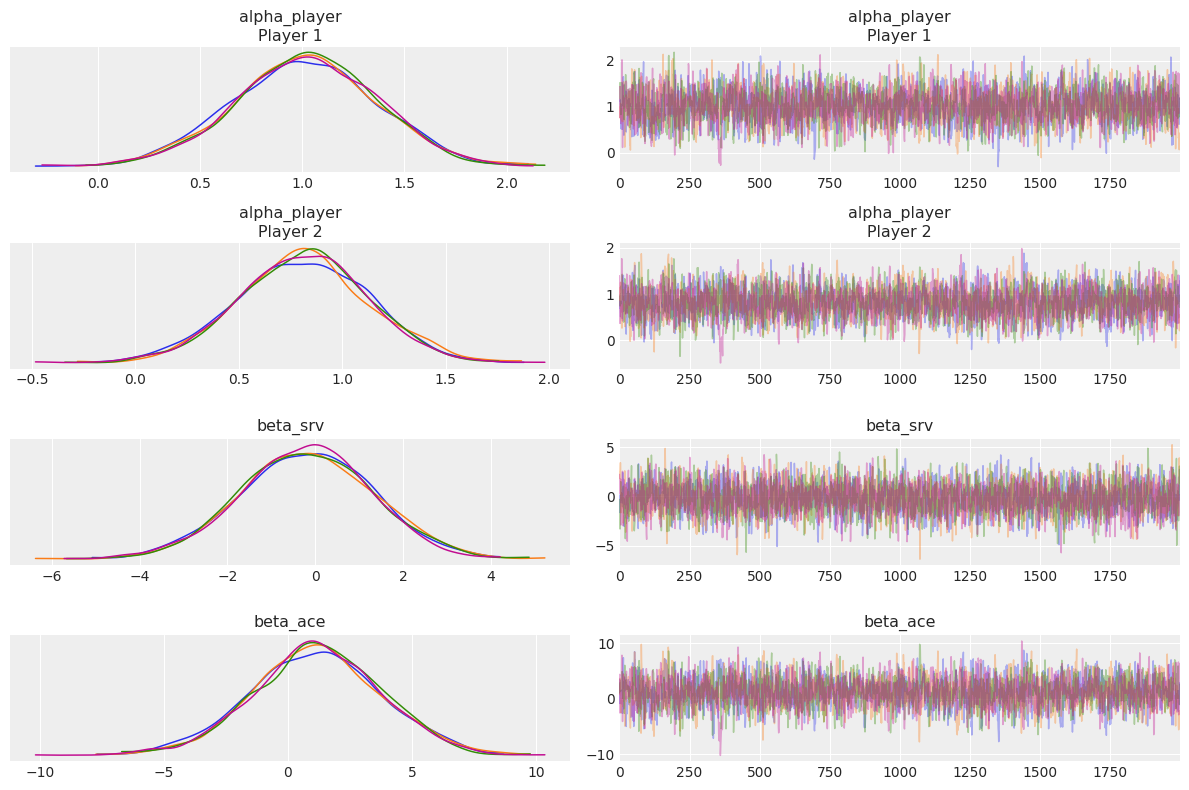

In [13]:
# 1. Summary Statistics
summary = az.summary(trace, var_names=["alpha_player", "beta_srv", "beta_ace"])
print(summary)

# 2. Trace Plot (Visual Convergence Check)
az.plot_trace(trace, var_names=["alpha_player", "beta_srv", "beta_ace"], compact=False)
plt.tight_layout()
plt.show()

## Sequential Inference (Key Innovation)
To answer the research question regarding uncertainty reduction over time, we refit the model at incremental windows (e.g., after 10 points, 20 points, etc.). This allows us to track the evolution of the coefficients and their credible intervals.

In [9]:
# Define windows for sequential fitting
windows = [10, 20, 50, 100, 150, 200, 250, len(y)]
traces_over_time = []

print(f"Starting sequential inference for {len(windows)} windows...")

for w in windows:
    print(f"  Fitting model with first {w} points...")
    
    # Subset Data
    server_sub = server_id[:w]
    srv_dev_sub = srv_deviation[:w]
    ace_dev_sub = ace_deviation[:w]
    y_sub = y[:w]
    
    with pm.Model() as model_t:
        # Priors (same as full model)
        alpha_t = pm.Normal("alpha_player", mu=0, sigma=1.5, shape=2)
        beta_srv_t = pm.Normal("beta_srv", mu=0, sigma=2)
        beta_ace_t = pm.Normal("beta_ace", mu=0, sigma=3)
        
        # Likelihood
        logit_t = alpha_t[server_sub] + beta_srv_t * srv_dev_sub + beta_ace_t * ace_dev_sub
        y_obs_t = pm.Bernoulli("y_obs", p=pm.math.invlogit(logit_t), observed=y_sub)
        
        # Efficient Sampling for iterative steps
        # Reduced chains/draws for intermediate steps to save time
        trace_t = pm.sample(draws=1000, tune=1000, chains=2, progressbar=False)
        traces_over_time.append(trace_t)

Starting sequential inference for 8 windows...
  Fitting model with first 10 points...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha_player, beta_srv, beta_ace]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 46 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...


  Fitting model with first 20 points...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha_player, beta_srv, beta_ace]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 53 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...


  Fitting model with first 50 points...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha_player, beta_srv, beta_ace]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 105 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


  Fitting model with first 100 points...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha_player, beta_srv, beta_ace]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 222 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...


  Fitting model with first 150 points...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha_player, beta_srv, beta_ace]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 329 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...


  Fitting model with first 200 points...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha_player, beta_srv, beta_ace]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 513 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


  Fitting model with first 250 points...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha_player, beta_srv, beta_ace]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 563 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...


  Fitting model with first 326 points...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha_player, beta_srv, beta_ace]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 788 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## Coefficient Evolution Analysis
We extract the mean and 90% credible intervals (quantile 0.05 to 0.95) for each parameter across all time windows. This visualizes how the model "learns" the game dynamics.

C:\Users\tanbe\AppData\Local\Temp\ipykernel_27900\4065030672.py:52: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


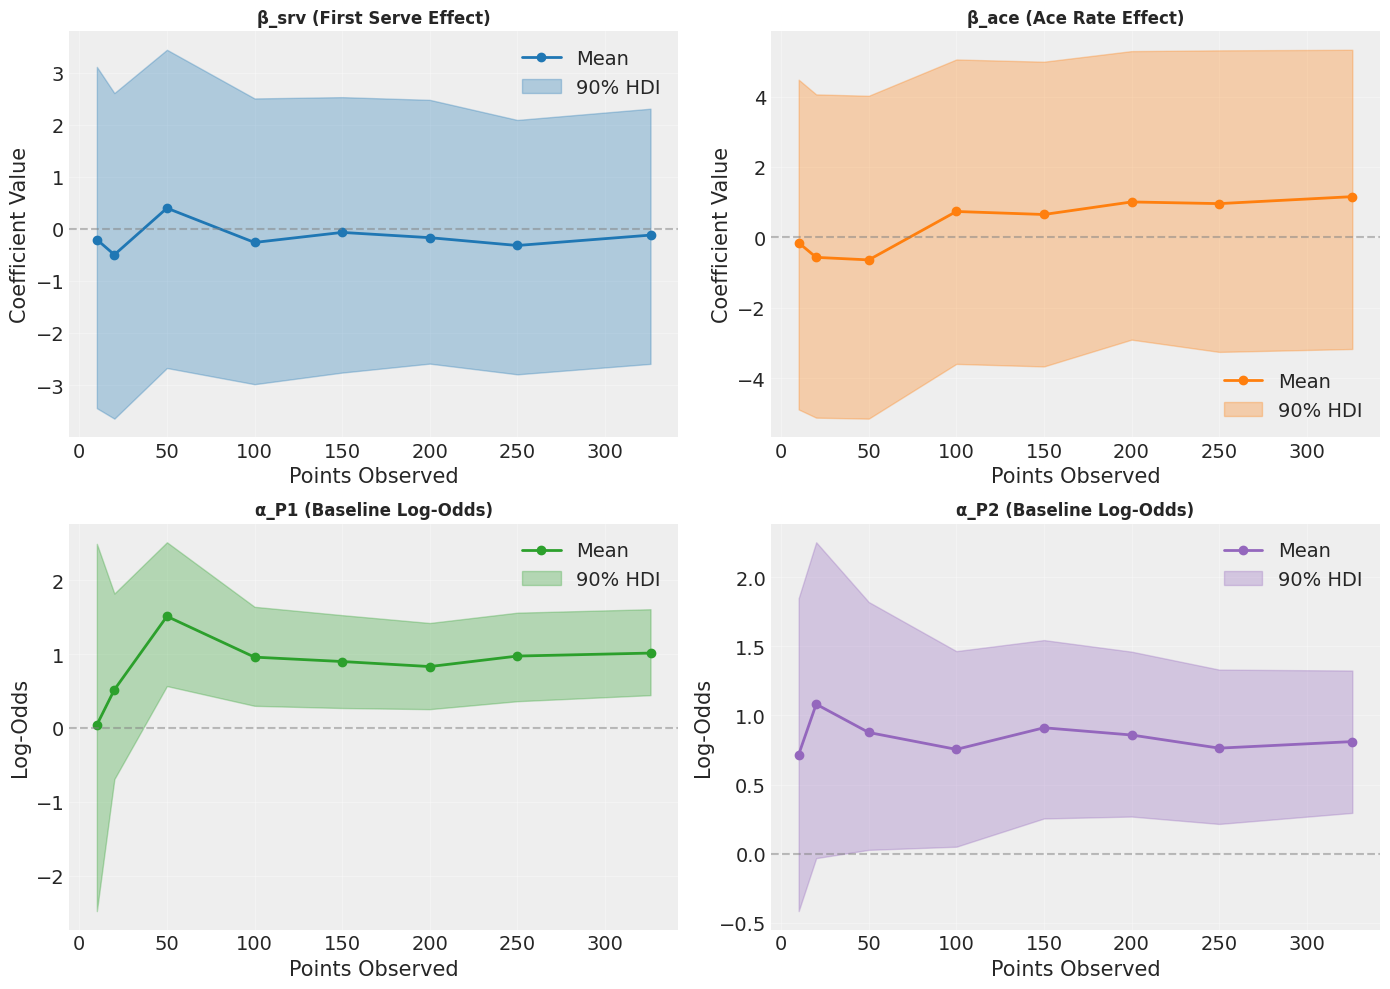

In [11]:
# Initialize storage
beta_srv_evo, beta_ace_evo = [], []
alpha_p1_evo, alpha_p2_evo = [], []

# Extract stats from traces
for t in traces_over_time:
    # Helper to get stats
    def get_stats(param_name, sel_idx=None):
        post = t.posterior[param_name]
        if sel_idx is not None:
            post = post.sel(alpha_player_dim_0=sel_idx)
        return {
            'mean': float(post.mean()),
            'q5': float(post.quantile(0.05)),
            'q95': float(post.quantile(0.95))
        }

    beta_srv_evo.append(get_stats('beta_srv'))
    beta_ace_evo.append(get_stats('beta_ace'))
    alpha_p1_evo.append(get_stats('alpha_player', 0))
    alpha_p2_evo.append(get_stats('alpha_player', 1))

# Plotting the 2x2 Grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

def plot_evolution(ax, data, title, ylabel, color):
    means = [d['mean'] for d in data]
    q5 = [d['q5'] for d in data]
    q95 = [d['q95'] for d in data]
    
    ax.plot(windows, means, marker='o', linewidth=2, color=color, label='Mean')
    ax.fill_between(windows, q5, q95, alpha=0.3, color=color, label='90% HDI')
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Points Observed')
    ax.legend()
    ax.grid(True, alpha=0.3)

# 1. Beta Serve
plot_evolution(axes[0, 0], beta_srv_evo, 'β_srv (First Serve Effect)', 'Coefficient Value', 'tab:blue')

# 2. Beta Ace
plot_evolution(axes[0, 1], beta_ace_evo, 'β_ace (Ace Rate Effect)', 'Coefficient Value', 'tab:orange')

# 3. Alpha P1
plot_evolution(axes[1, 0], alpha_p1_evo, 'α_P1 (Baseline Log-Odds)', 'Log-Odds', 'tab:green')

# 4. Alpha P2
plot_evolution(axes[1, 1], alpha_p2_evo, 'α_P2 (Baseline Log-Odds)', 'Log-Odds', 'tab:purple')

plt.tight_layout()
plt.show()

In [12]:
#save the full InferenceData object (NetCDF format) for the final reporting notebook.

trace.to_netcdf(RESULTS_DIR / 'trace_final.nc')

evolution_data = {
    'windows': windows,
    'beta_srv': beta_srv_evo,
    'beta_ace': beta_ace_evo,
    'alpha_p1': alpha_p1_evo,
    'alpha_p2': alpha_p2_evo
}

with open(RESULTS_DIR / 'coefficient_evolution.pkl', 'wb') as f:
    pickle.dump(evolution_data, f)